In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dependencies and Setup
import time
from pprint import pprint
import requests
from datetime import date, timedelta, datetime
import json
from pprint import pprint
from tqdm import tqdm
from tqdm import tqdm_notebook
# sqlite Dependencies
# ----------------------------------
# Imports the method used for connecting to DBs
from sqlalchemy import create_engine
# Allow us to declare column types
from sqlalchemy import Column, Integer, String, Text, DateTime, Float, Boolean, ForeignKey
from sqlalchemy.orm import relationship
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session

In [2]:
from nba_api.stats.endpoints import playercareerstats, drafthistory, commonplayerinfo, playerawards

In [3]:
# Not used
# cumestatsplayer,draftcombinedrillresults,playerdashboardbyteamperformance, leagueleaders, leaguedashplayerstats, draftcombinenonstationaryshooting, draftcombinestats, commonallplayers,

-------------

# Open Saved JSON

In [3]:
with open('./_players_all_data.json') as json_file:
    data = json.load(json_file)

In [4]:
#  Player positions
player_positions = pd.read_csv('../../datasets/nba_positions_no_team.csv') 

--------------

#### Key: 

* GP: Games Played
* MIN: Minutes Played
* FGM: Field Goals Made
* FGA: Field Goals Attempted
* FG%: Field Goal Percentage
* 3PM: 3 Point Field Goals Made
* 3PA: 3 Point Field Goals Attempted
* 3P%: 3 Point Field Goals Percentage
* FTM: Free Throws Made
* FTA: Free Throws Attempted
* FT%: Free Throw Percentage
* OREB: Offensive Rebounds
* DREB: Defensive Rebounds
* REB: Rebounds
* AST: Assists
* TOV: Turnovers
* STL: Steals
* BLK: Blocks
* PF: Personal Fouls
* DD2: Double Doubles
* TD3: Trible Doubles
* PTS: Points
* YIL: Year in League




## Clean df and add columns

add Points Per Games Played (PPGP), add position

In [5]:
five_year_all_players = pd.read_json(data)
twenty_years_all_players_raw = five_year_all_players[five_year_all_players['SEASON_ID'] > '1999-00']
twenty_years_all_players_raw = twenty_years_all_players_raw.join(player_positions.set_index('PLAYER_NAME'), on='PLAYER_NAME')
twenty_years_all_players_raw = twenty_years_all_players_raw.dropna(how='any').sort_values(by=['YIL'], ascending=True).drop_duplicates( keep='first').reset_index(drop=True)
twenty_years_all_players_raw['PPGP'] = round(twenty_years_all_players_raw['PTS'] / twenty_years_all_players_raw['GP'], 2)
twenty_years_all_players = twenty_years_all_players_raw.copy()
twenty_years_all_players

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,AST,STL,BLK,TOV,PF,PTS,YIL,PLAYER_NAME,POSITION,PPGP
0,2043,2000-01,0,1610612765,DET,23,78,8.0,1266.0,160,...,207,49.0,1.0,139.0,153,422,1,Mateen Cleaves,PG,5.41
1,2738,2004-05,0,1610612755,PHI,21,82,82.0,2688.0,269,...,246,138.0,48.0,139.0,204,741,1,Andre Iguodala,SG,9.04
2,203096,2012-13,0,1610612738,BOS,21,45,5.0,892.0,111,...,35,22.0,22.0,29.0,154,270,1,Jared Sullinger,C,6.00
3,203094,2012-13,0,1610612753,ORL,23,75,28.0,1249.0,256,...,44,24.0,32.0,79.0,133,587,1,Andrew Nicholson,F,7.83
4,203081,2012-13,0,1610612757,POR,22,82,82.0,3167.0,553,...,531,74.0,19.0,243.0,172,1562,1,Damian Lillard,PG,19.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5322,2211,2005-06,0,1610612744,GSW,26,74,74.0,2516.0,363,...,101,47.0,26.0,108.0,191,1035,5,Troy Murphy,PF,13.99
5323,200746,2010-11,0,1610612757,POR,25,81,81.0,3211.0,707,...,170,82.0,94.0,153.0,220,1769,5,LaMarcus Aldridge,PF,21.84
5324,200751,2010-11,0,1610612746,LAC,27,63,24.0,1551.0,206,...,170,47.0,21.0,95.0,122,616,5,Randy Foye,SG,9.78
5325,202339,2014-15,0,1610612756,PHX,25,81,81.0,2800.0,468,...,493,127.0,45.0,274.0,189,1377,5,Eric Bledsoe,PG,17.00


--------------------

## Linear Regression 

In [55]:
twenty_years_all_players

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,AST,STL,BLK,TOV,PF,PTS,YIL,PLAYER_NAME,POSITION,PPGP
0,2544,2005-06,0,1610612739,CLE,21,79,79.0,3361.0,875,...,521,123.0,66.0,260.0,181,2478,3,LeBron James,SF,31.37
1,201142,2009-10,0,1610612760,OKC,21,82,82.0,3239.0,794,...,231,112.0,84.0,271.0,171,2472,3,Kevin Durant,SF,30.15
2,2240,2005-06,0,1610612764,WAS,24,80,80.0,3384.0,746,...,484,161.0,25.0,297.0,286,2346,5,Gilbert Arenas,PG,29.32
3,2544,2007-08,0,1610612739,CLE,23,75,74.0,3027.0,794,...,539,138.0,81.0,255.0,165,2250,5,LeBron James,SF,30.00
4,947,2000-01,0,1610612755,PHI,26,71,71.0,2976.0,762,...,325,178.0,20.0,237.0,147,2207,5,Allen Iverson,SG,31.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5322,202918,2017-18,0,1610612738,BOS,30,2,0.0,8.0,0,...,0,1.0,0.0,0.0,1,0,2,Xavier Silas,G,0.00
5323,204067,2017-18,0,1610612738,BOS,26,2,0.0,6.0,0,...,0,1.0,0.0,0.0,0,0,3,Jarell Eddie,F,0.00
5324,2062,2002-03,0,1610612744,GSW,25,2,0.0,9.0,0,...,2,1.0,0.0,1.0,0,0,3,A.J. Guyton,G,0.00
5325,204067,2017-18,0,1610612741,CHI,26,1,0.0,3.0,0,...,0,0.0,0.0,0.0,0,0,3,Jarell Eddie,F,0.00


In [56]:
# Assign the data to X and y

X = twenty_years_all_players[["MIN", "GP"]]
y = twenty_years_all_players["PPGP"].values.reshape(-1, 1)
print(X.shape, y.shape)

(5327, 2) (5327, 1)


In [57]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create the model using LinearRegression

from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [58]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)


print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.7590783486450451
Testing Score: 0.7698238497482489


Text(0.5, 1.0, 'Residual Plot')

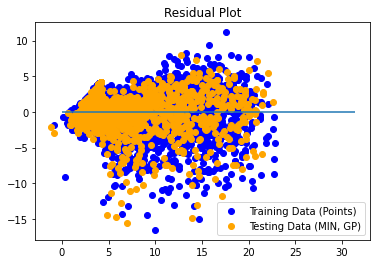

In [59]:
# Plot the Residuals for the Training and Testing data

# Use `model.predict()` to get a prediction array from X_train and X_test
y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

# Plot the residual
plt.scatter(y_train_prediction, y_train_prediction - y_train, c="blue", label="Training Data (Points)")
plt.scatter(y_test_prediction, y_test_prediction - y_test, c="orange", label="Testing Data (MIN, GP)")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")


--------------------------

## Logistic Regression
* Assiging 'dummies'.        
Creating columns for logistic regression out of categorical data in specific columns. ex: positon of player

In [7]:
# twenty_years_all_players

In [8]:
ml_test = twenty_years_all_players.drop(columns=['PLAYER_NAME','TEAM_ABBREVIATION','SEASON_ID'])

In [60]:
ml_test2 = pd.get_dummies(ml_test)
ml_test2.columns = ml_test2.columns.str.replace(' ','')
ml_test2.head()

,PLAYER_ID,LEAGUE_ID,TEAM_ID,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,...,PPGP,POSITION_C,POSITION_F,POSITION_G,POSITION_GF,POSITION_NA,POSITION_PF,POSITION_PG,POSITION_SF,POSITION_SG
0,2544,0,1610612739,21,79,79.0,3361.0,875,1823,0.480,...,31.37,0,0,0,0,0,0,0,1,0
1,201142,0,1610612760,21,82,82.0,3239.0,794,1668,0.476,...,30.15,0,0,0,0,0,0,0,1,0
2,2240,0,1610612764,24,80,80.0,3384.0,746,1668,0.447,...,29.32,0,0,0,0,0,0,1,0,0
3,2544,0,1610612739,23,75,74.0,3027.0,794,1642,0.484,...,30.00,0,0,0,0,0,0,0,1,0
4,947,0,1610612755,26,71,71.0,2976.0,762,1813,0.420,...,31.08,0,0,0,0,0,0,0,0,1


OREB: Offensive Rebounds  
DREB: Defensive Rebounds   
REB: Rebounds  
AST: Assists  
TOV: Turnovers  
STL: Steals  
BLK: Blocks  

In [61]:
X = ml_test2[["MIN", "GP"]]
# Select the 'FEV' column for y, and then use values.reshape() to reshape it to a 2d array
y = ml_test2["POSITION_C"].values.reshape(-1, 1)

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.33,)



In [63]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [64]:
classifier.fit(X_train, y_train)

C:\Users\pompa\anaconda3\envs\usc_bootcamp\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

In [65]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.8119921546651723
Testing Data Score: 0.8213879408418657


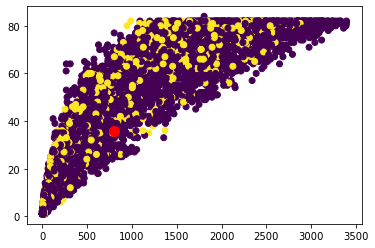

In [67]:
# Generate a new data point (the red circle)
import numpy as np
new_data = np.array([[800, 36]])
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y) 
plt.scatter(new_data[0, 0], new_data[0, 1], c="r", marker="o", s=100)

In [68]:
# Predict the class (purple or yellow) of the new data point
predictions = classifier.predict(new_data)
print("Classes are either 0 (purple) or 1 (yellow)")
print(f"The new point was classified as: {predictions}")

Classes are either 0 (purple) or 1 (yellow)
The new point was classified as: [0]


In [69]:
predictions = classifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test})

Exception: Data must be 1-dimensional

----------

## TEST: DNN for regression    
https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33

In [74]:
X = ml_test2[["MIN", "GP"]]
# Select the 'FEV' column for y, and then use values.reshape() to reshape it to a 2d array
y = ml_test2["POSITION_C"].values.reshape(-1, 1)

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, test_size=0.33)

In [78]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [79]:
# define a function to get the columns that don’t have any missing values
num_cols = get_cols_with_no_nans(ml_test2 , 'num')
cat_cols = get_cols_with_no_nans(ml_test2 , 'no_num')

In [80]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 36
Number of nun-numerical columns with no nan values : 0


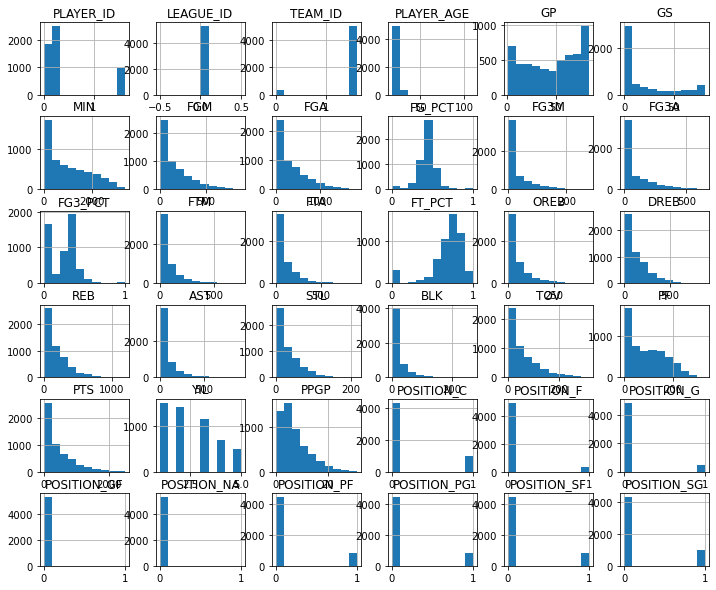

In [81]:
combined = ml_test2[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

In [82]:
import seaborn as sb

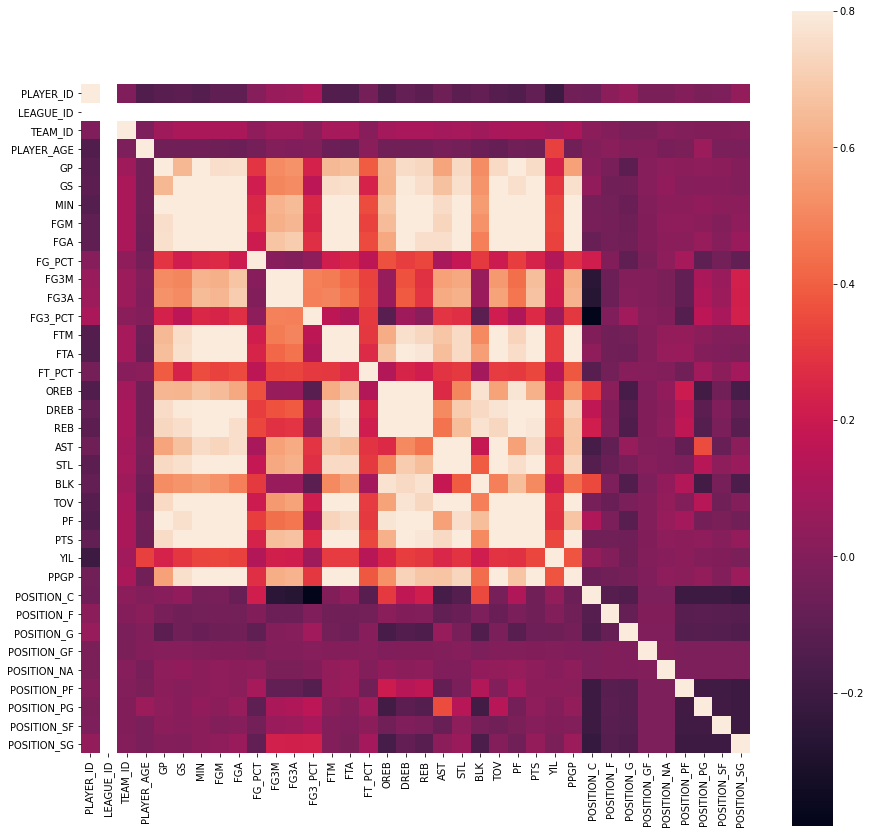

In [90]:
train_data = combined[num_cols + cat_cols]
train_data['POSITION_C'] = y 

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [91]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 36 columns before encoding categorical features
There are 36 columns after encoding categorical features


In [92]:
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test 
  
train, test = split_combined()

-----------

## TEST: DNN.
Sequential model, dense layers, relu as activation function for hidden layers, normal initializer as kernel_initializer. Mean absolute error as loss function. Linear as activation function for output

In [35]:
# first, create a normal neural network with 2 inputs, 6 hidden nodes, and 2 outputs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.utils import to_categorical

In [36]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)

In [37]:
# Transform the training and testing data using the X_scaler

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [38]:
# One-hot encoding
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [39]:
# first, create a normal neural network with 2 inputs, 6 hidden nodes, and 2 outputs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

model = Sequential()
model.add(Dense(units=6, activation='relu', input_dim=2, name='hidden'))
model.add(Dense(units=2, activation='softmax', name='output'))

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 6)                 18        
_________________________________________________________________
output (Dense)               (None, 2)                 14        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [43]:
# Fit the model to the training data
model.fit(
    X_train_scaled,
    y_train_categorical,
    validation_data=(X_test_scaled, y_test_categorical),
    epochs=60,
    shuffle=True,
    verbose=2
)

Epoch 1/60
112/112 - 0s - loss: 0.8997 - accuracy: 0.5310 - val_loss: 0.7358 - val_accuracy: 0.5745
Epoch 2/60
112/112 - 0s - loss: 0.6525 - accuracy: 0.6307 - val_loss: 0.5601 - val_accuracy: 0.7514
Epoch 3/60
112/112 - 0s - loss: 0.5334 - accuracy: 0.7955 - val_loss: 0.4912 - val_accuracy: 0.8259
Epoch 4/60
112/112 - 0s - loss: 0.4957 - accuracy: 0.8098 - val_loss: 0.4732 - val_accuracy: 0.8259
Epoch 5/60
112/112 - 0s - loss: 0.4873 - accuracy: 0.8098 - val_loss: 0.4691 - val_accuracy: 0.8259
Epoch 6/60
112/112 - 0s - loss: 0.4855 - accuracy: 0.8098 - val_loss: 0.4678 - val_accuracy: 0.8259
Epoch 7/60
112/112 - 0s - loss: 0.4850 - accuracy: 0.8098 - val_loss: 0.4669 - val_accuracy: 0.8259
Epoch 8/60
112/112 - 0s - loss: 0.4846 - accuracy: 0.8098 - val_loss: 0.4661 - val_accuracy: 0.8259
Epoch 9/60
112/112 - 0s - loss: 0.4843 - accuracy: 0.8098 - val_loss: 0.4657 - val_accuracy: 0.8259
Epoch 10/60
112/112 - 0s - loss: 0.4840 - accuracy: 0.8098 - val_loss: 0.4650 - val_accuracy: 0.8259

### TEST: Deep Learning

In [50]:
deep_model = Sequential(name='deep_model')
deep_model.add(Dense(units=6, activation='relu', input_dim=2, name='hidden'))
deep_model.add(Dense(units=6, activation='relu', name='hidden_2'))
deep_model.add(Dense(units=2, activation='softmax', name='output'))

In [51]:
deep_model.summary()

Model: "deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 6)                 18        
_________________________________________________________________
hidden_2 (Dense)             (None, 6)                 42        
_________________________________________________________________
output (Dense)               (None, 2)                 14        
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


In [52]:
# deep_model.compile(optimizer='adam',
#                    loss='categorical_crossentropy',
#                    metrics=['accuracy'])

# deep_model.compile(optimizer='adam',
#                    loss='mean_absolute_error',
#                    metrics=['mean_absolute_error'])
# deep_model.fit(
#     X_train_scaled,
#     y_train_categorical,
#     validation_data=(X_test_scaled, y_test_categorical),
#     epochs=100,
#     shuffle=True,
#     verbose=2
# )

In [54]:
deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
deep_model.fit(
    X_train_scaled,
    y_train_categorical,
    validation_data=(X_test_scaled, y_test_categorical),
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
112/112 - 0s - loss: 0.5802 - accuracy: 0.7674 - val_loss: 0.4847 - val_accuracy: 0.8259
Epoch 2/100
112/112 - 0s - loss: 0.4915 - accuracy: 0.8098 - val_loss: 0.4724 - val_accuracy: 0.8259
Epoch 3/100
112/112 - 0s - loss: 0.4896 - accuracy: 0.8098 - val_loss: 0.4717 - val_accuracy: 0.8259
Epoch 4/100
112/112 - 0s - loss: 0.4890 - accuracy: 0.8098 - val_loss: 0.4714 - val_accuracy: 0.8259
Epoch 5/100
112/112 - 0s - loss: 0.4884 - accuracy: 0.8098 - val_loss: 0.4699 - val_accuracy: 0.8259
Epoch 6/100
112/112 - 0s - loss: 0.4881 - accuracy: 0.8098 - val_loss: 0.4702 - val_accuracy: 0.8259
Epoch 7/100
112/112 - 0s - loss: 0.4875 - accuracy: 0.8098 - val_loss: 0.4699 - val_accuracy: 0.8259
Epoch 8/100
112/112 - 0s - loss: 0.4872 - accuracy: 0.8098 - val_loss: 0.4689 - val_accuracy: 0.8259
Epoch 9/100
112/112 - 0s - loss: 0.4868 - accuracy: 0.8098 - val_loss: 0.4684 - val_accuracy: 0.8259
Epoch 10/100
112/112 - 0s - loss: 0.4864 - accuracy: 0.8098 - val_loss: 0.4681 - val_accura

Epoch 82/100
112/112 - 0s - loss: 0.4814 - accuracy: 0.8098 - val_loss: 0.4607 - val_accuracy: 0.8259
Epoch 83/100
112/112 - 0s - loss: 0.4815 - accuracy: 0.8098 - val_loss: 0.4612 - val_accuracy: 0.8259
Epoch 84/100
112/112 - 0s - loss: 0.4813 - accuracy: 0.8098 - val_loss: 0.4607 - val_accuracy: 0.8259
Epoch 85/100
112/112 - 0s - loss: 0.4813 - accuracy: 0.8098 - val_loss: 0.4600 - val_accuracy: 0.8259
Epoch 86/100
112/112 - 0s - loss: 0.4813 - accuracy: 0.8098 - val_loss: 0.4606 - val_accuracy: 0.8259
Epoch 87/100
112/112 - 0s - loss: 0.4815 - accuracy: 0.8098 - val_loss: 0.4603 - val_accuracy: 0.8259
Epoch 88/100
112/112 - 0s - loss: 0.4813 - accuracy: 0.8098 - val_loss: 0.4606 - val_accuracy: 0.8259
Epoch 89/100
112/112 - 0s - loss: 0.4814 - accuracy: 0.8098 - val_loss: 0.4604 - val_accuracy: 0.8259
Epoch 90/100
112/112 - 0s - loss: 0.4811 - accuracy: 0.8098 - val_loss: 0.4608 - val_accuracy: 0.8259
Epoch 91/100
112/112 - 0s - loss: 0.4810 - accuracy: 0.8098 - val_loss: 0.4600 - v

### Compare the models below

In [48]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

55/55 - 0s - loss: 0.4607 - accuracy: 0.8259
Normal Neural Network - Loss: 0.46072763204574585, Accuracy: 0.8259385824203491


In [49]:
model_loss, model_accuracy = deep_model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(f"Deep Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

55/55 - 0s - loss: 0.4600 - accuracy: 0.8259
Deep Neural Network - Loss: 0.46001899242401123, Accuracy: 0.8259385824203491


-----------------

In [103]:
import tensorflow.keras as keras

In [107]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

--------

### Mean Square Error

In [70]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2

from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, y_test_prediction)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

NameError: name 'y_test_scaled' is not defined

In [71]:
# LASSO model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=.01)

lasso.fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

NameError: name 'y_train_scaled' is not defined

In [72]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01)
ridge.fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

NameError: name 'y_train_scaled' is not defined

In [ ]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01)
elasticnet.fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")


---------------

## YIL variables

In [73]:
### DF for each year. decending
first_year = twenty_years_all_players[twenty_years_all_players['YIL'] == 1]
second_year = twenty_years_all_players[twenty_years_all_players['YIL'] == 2]
third_year = twenty_years_all_players[twenty_years_all_players['YIL'] == 3]
fourth_year = twenty_years_all_players[twenty_years_all_players['YIL'] == 4]
fifth_year = twenty_years_all_players[twenty_years_all_players['YIL'] == 5]

## Plot YIL to Total Points

First Year Total Points per Position

In [ ]:
import plotly.express as px

fig = px.scatter(twenty_years_all_players, x="MIN", y="PTS", log_x=True, hover_name="PLAYER_NAME", hover_data=["PTS", 'SEASON_ID', 'TEAM_ABBREVIATION'], color="YIL",
                 size='PTS', title="First Year Total Points per Position")
fig.show()

Second Year Total Points per Position

In [ ]:
import plotly.express as px

fig = px.scatter(second_year, x="PTS", y="POSITION", log_x=True, hover_name="PLAYER_NAME", hover_data=["PTS"], color="PTS",
                 size='PTS', title="Second Year Total Points per Position")
fig.show()

In [ ]:
test = list(first_year.columns.values)

In [ ]:
fig = px.scatter_polar(first_year, r="PTS", theta="POSITION", color="PTS",
                    template="plotly_dark", title="First Year Total Points per Position")
fig.show()

In [ ]:
twenty_years_all_players[['YIL','PTS','STL','BLK','REB','MIN','AST','TOV']].columns

https://plotly.com/python/polar-chart/

In [ ]:
# import plotly.express as px
# df = px.data.wind()
# fig = px.line_polar(twenty_years_all_players, r="PTS", theta="POSITION", color="YIL", line_close=True,
#                     color_discrete_sequence=px.colors.sequential.Plasma_r,
#                     template="plotly_dark",)
# fig.show()

In [ ]:
# df = px.data.wind()
# df